In [1]:
import matplotlib.pyplot as plt

import warnings
from glob import glob #library that helps us search for files

import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer


warnings.simplefilter(action="ignore", category=FutureWarning)


In [2]:
def wrangle(filepath):
    df=pd.read_excel(filepath)
    
    #to extract capital federal from place_with_parent_names column
    df['state']=df['place_with_parent_names'].str.split('|',expand=True)[2]
    

    #subset apartments in capital federal less than $400,000
    mask_price=df['price_aprox_usd']<400000.0
    mask_state=df['state']=='Capital Federal'
    mask_type=df['property_type']=='apartment'
    df= df[mask_state & mask_type & mask_price ]
        
    #to remove outliers from surface_covered_in_m2
    mini,maxi=df['surface_covered_in_m2'].quantile([0.1,0.9])
    mask=df['surface_covered_in_m2'].between(mini,maxi)
    df=df[mask]
    
    #separate lat-lon column
    df[['lat','lon']]= df['lat-lon'].str.split(',',expand=True)
    df.drop(['lat-lon'],axis=1,inplace=True)
    df[['lat','lon']]=df[['lat','lon']].astype(float)
    
    #subset neighborhood
    df['neighborhood']=df['place_with_parent_names'].str.split('|',expand=True)[3]
    df.drop(['place_with_parent_names'],axis=1,inplace=True)
    
    #drop missing values
    cols=df[['floor','expenses']]
    df.drop(cols,axis=1,inplace=True)

    #dropping columns with high and low cardinality
    cols=df[['operation','properati_url','property_type','currency']]
    df.drop(cols,axis=1,inplace=True)
    
    #dropping leaky columns
    cols=df[['price','price_aprox_local_currency','price_per_m2','price_usd_per_m2',]]
    df.drop(cols,axis=1,inplace=True)
    
    #dropping multicorrelated columns
    df.drop(columns=['surface_total_in_m2','rooms'],inplace=True)
    
    return df
    
    

In [3]:
#import files
files=glob("/Users/bambino/Documents/DATASETS/Buenos-aires-*.xlsx")
files

['/Users/bambino/Documents/DATASETS\\Buenos-aires-1.xlsx',
 '/Users/bambino/Documents/DATASETS\\Buenos-aires-2.xlsx',
 '/Users/bambino/Documents/DATASETS\\Buenos-aires-3.xlsx',
 '/Users/bambino/Documents/DATASETS\\Buenos-aires-4.xlsx',
 '/Users/bambino/Documents/DATASETS\\Buenos-aires-5.xlsx']

In [4]:
dataframes=[wrangle(i) for i in files]

In [5]:
dataframes[0]

,price_aprox_usd,surface_covered_in_m2,state,lat,lon,neighborhood
4,129000.00,70.0,Capital Federal,-34.584651,-58.454693,Chacarita
9,87000.00,42.0,Capital Federal,-34.638979,-58.500115,Villa Luro
29,118000.00,54.0,Capital Federal,-34.615847,-58.459957,Caballito
40,57000.00,42.0,Capital Federal,-34.625222,-58.382382,Constitución
41,90000.00,50.0,Capital Federal,-34.610610,-58.412511,Once
...,...,...,...,...,...,...
8589,73536.95,42.0,Capital Federal,-34.631591,-58.370191,Barracas
8590,119000.00,41.0,Capital Federal,-34.604555,-58.418206,Almagro
8593,62000.00,43.0,Capital Federal,-34.624002,-58.390588,Barracas
8601,125000.00,70.0,Capital Federal,-34.601455,-58.378132,San Nicolás


In [6]:
#concatenate all dataframes into a single one
df=pd.concat(dataframes)


In [7]:
df.head()

,price_aprox_usd,surface_covered_in_m2,state,lat,lon,neighborhood,Unnamed: 0
4,129000.0,70.0,Capital Federal,-34.584651,-58.454693,Chacarita,NaN
9,87000.0,42.0,Capital Federal,-34.638979,-58.500115,Villa Luro,NaN
29,118000.0,54.0,Capital Federal,-34.615847,-58.459957,Caballito,NaN
40,57000.0,42.0,Capital Federal,-34.625222,-58.382382,Constitución,NaN
41,90000.0,50.0,Capital Federal,-34.610610,-58.412511,Once,NaN


In [8]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6582 entries, 4 to 8597
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   state                  6582 non-null   object 
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
dtypes: float64(4), object(2)
memory usage: 360.0+ KB


<AxesSubplot:>

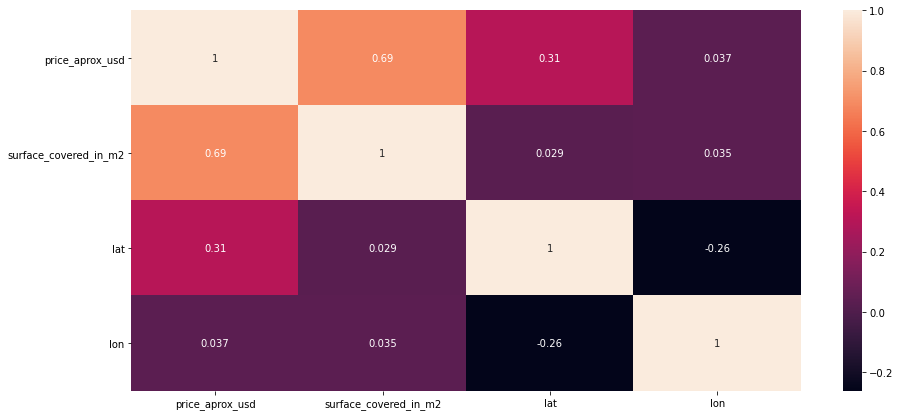

In [10]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True)

In [11]:
#check for categorical columns with high or low cardinality

In [12]:
df_object=df.select_dtypes(include='object')
df_object.head()

,state,neighborhood
4,Capital Federal,Chacarita
9,Capital Federal,Villa Luro
29,Capital Federal,Caballito
40,Capital Federal,Constitución
41,Capital Federal,Once


In [13]:
#df_object['property_type'].value_counts()

In [14]:
#df_object['operation'].value_counts()

In [15]:
#df_object['currency'].value_counts()

In [16]:
#df_object['properati_url'].value_counts()

In [17]:
#df_object['state'].value_counts()

In [18]:
#df_object['neighborhood'].value_counts()

In [19]:
#modifying wrangle function to drop low and high cardinality columns

### Split

In [20]:
target = "price_aprox_usd"
predictor=['surface_covered_in_m2','lat','lon','neighborhood']
X_train=df[predictor]
y_train=df[target]

### Baseline 

In [21]:
y_mean=y_train.mean()

In [22]:
y_base=[y_mean]*len(y_train)

In [23]:
base_mae=mean_absolute_error(y_base,y_train)
print("Mean apt price:", y_mean)

print("Baseline MAE:", base_mae)

Mean apt price: 132383.83701458527
Baseline MAE: 44860.10834274134


### Pipeline

In [24]:
model = make_pipeline(OneHotEncoder(),SimpleImputer(),Ridge())
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['neighborhood'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [25]:
y_pred_train=model.predict(X_train)

In [26]:
y_pred_train

array([161161.31914386,  91309.519214  , 130441.28527109, ...,
        80779.62249321,  93662.14427993,  94474.33810382])

### Evaluate model

In [27]:
y_train_mae=mean_absolute_error(y_train,y_pred_train)
print("Training MAE:", y_train_mae)

Training MAE: 24207.107190330244


### Test model

In [28]:
X_test = pd.read_excel("/Users/bambino/Documents/DATASETS/Buenos-aires_realestate-testfeatures.xlsx")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

### Deployment

In [29]:
def make_prediction(area, lat, lon, neighborhood):
    data={
        'surface_covered_in_m2':area,
        'lat':lat,
        'lon':lon,
        'neighborhood':neighborhood
    }
    df=pd.DataFrame(data,index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [30]:
make_prediction(110.0,-34.584651,-58.454693,'Barracas')

'Predicted apartment price: $238377.7'

In [31]:
make_prediction(150.0,-34.610610,-58.412511,'Once')

'Predicted apartment price: $304824.81'

In [32]:
make_prediction(200,-34.615847,-58.459957,'Caballito')

'Predicted apartment price: $453378.48'

### Deployment with an interactive dashboard

In [33]:
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact


In [35]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…